# Session 7: Systemic Risk and Financial Contagion

## Summer School: Network and Graph Theory for Financial Markets and Economic Systems

**Session Goals:**
By the end of this session, you will:
1. Understand systemic risk through a network lens
2. Master the DebtRank algorithm for measuring systemic importance
3. Simulate financial contagion cascades
4. Identify systemically important institutions
5. Design optimal intervention strategies

**Practical Application:**
Build a complete systemic risk framework for stress testing banking networks and evaluating regulatory interventions

**Duration:** 3.5 hours

---


## Motivation: The Network Nature of Systemic Risk

### What is Systemic Risk?

**Definition:** Risk that the failure of one institution triggers a cascade of failures, threatening the entire financial system.

**Key insight:** Systemic risk ≠ Sum of individual risks
- Network effects amplify shocks
- Interconnections create vulnerability
- "Too interconnected to fail"

### The 2008 Financial Crisis

**Lehman Brothers collapse (Sept 15, 2008):**
- Single institution failure
- Cascaded through counterparty exposures
- Credit markets froze globally
- Required massive government intervention

**Network perspective:**
- Lehman was highly connected (high degree)
- Central position (high betweenness)
- Large exposures to other institutions
- Failure propagated through network

**Cost:** $10+ trillion in lost output globally

### Why Traditional Risk Measures Fail

**VaR (Value at Risk):**
- Institution-level only
- Ignores interconnections
- Assumes independence
- Failed to predict 2008 crisis

**Capital requirements:**
- Based on balance sheet size
- Not network position
- Miss "too interconnected to fail"

**Need:** Network-based systemic risk measures!

### The "Too Big to Fail" Problem

**Size vs Interconnectedness:**

**Example 1:** Large but isolated institution
- Failure contained
- Limited spillovers
- Not systemically important

**Example 2:** Small but highly connected institution
- Failure spreads widely
- Many counterparties affected
- Highly systemically important!

**Key insight:** Network position matters more than size

### Types of Financial Contagion

**1. Direct contagion (counterparty risk):**
- Bank A fails → Cannot pay Bank B
- Bank B suffers losses
- May trigger Bank B's failure
- Cascade continues

**2. Indirect contagion (fire sales):**
- Bank A forced to sell assets
- Asset prices drop
- Bank B holds same assets → Losses
- Mark-to-market losses spread

**3. Information contagion:**
- Bank A fails
- Investors worry about similar banks
- Funding withdrawals
- Liquidity crisis spreads

**We focus on direct contagion (tractable, important)**

### Key Questions

**1. Measurement:**
- Which institutions are systemically important?
- How to quantify systemic risk?
- Beyond size: network position?

**2. Propagation:**
- How do shocks cascade?
- What amplifies contagion?
- Where do cascades stop?

**3. Prevention:**
- How to make system more resilient?
- Optimal capital buffers?
- Which institutions to regulate most?

**4. Intervention:**
- When should regulator intervene?
- Which institutions to rescue?
- Optimal bailout strategy?

### Our Approach

**Framework:**
1. Model financial network (from Session 5!)
2. Introduce shock to one institution
3. Simulate cascade through network
4. Measure systemic impact
5. Identify key vulnerabilities
6. Design interventions

**Tools:**
- DebtRank algorithm (Battiston et al. 2012)
- Cascade simulations
- Network centrality (Session 3!)
- Stress testing


---
## Setup and Imports


In [4]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats, linalg
from collections import defaultdict

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
%matplotlib inline

# Reproducibility
np.random.seed(42)

print("="*70)
print("ENVIRONMENT CONFIGURED")
print("="*70)
print(f"  NumPy version: {np.__version__}")
print(f"  NetworkX version: {nx.__version__}")
print(f"  Pandas version: {pd.__version__}")
print("\nReady for systemic risk analysis!")


ENVIRONMENT CONFIGURED
  NumPy version: 1.26.4
  NetworkX version: 3.2.1
  Pandas version: 2.2.2

Ready for systemic risk analysis!


---
# Part 1: The DebtRank Algorithm

## 1.1 Motivation

**Problem:** How to measure systemic importance?

**Traditional approaches:**
- Size (total assets)
- Leverage (debt/equity)
- Interconnectedness (degree)

**Limitation:** Don't capture cascade potential!

**DebtRank solution:** Measures both direct and indirect impacts through cascade simulation

## 1.2 Mathematical Framework

### Network Setup

**Financial network:**
- $n$ institutions (banks)
- $A_{ij}$ = exposure of bank $i$ to bank $j$ (liability)
- $E_i$ = equity (capital) of bank $i$
- $A_i = \sum_j A_{ij}$ = total assets of bank $i$

**Relative exposures:**
$$W_{ij} = \frac{A_{ij}}{A_i}$$

Fraction of $i$'s assets exposed to $j$.

### Bank States

Each bank $i$ has state $h_i(t) \in [0,1]$:

**States:**
- $h_i = 0$: Healthy (no distress)
- $0 < h_i < 1$: Distressed (partial loss)
- $h_i = 1$: Failed (complete loss)

**Interpretation:** $h_i$ = fraction of equity lost

### Cascade Dynamics

**Initial shock:** Bank $j$ loses fraction $\epsilon$ of equity
$$h_j(0) = \epsilon$$

**Impact on counterparty $i$:**

Loss to $i$ from $j$'s distress:
$$L_{ij} = W_{ij} \cdot h_j \cdot A_j$$

New distress level of $i$:
$$h_i(t+1) = \min\left(1, h_i(t) + \frac{\sum_j L_{ij}}{E_i}\right)$$

**Interpretation:**
- Bank $j$ in distress $h_j$
- Can only repay $(1-h_j)$ of obligations
- Bank $i$ loses $h_j \cdot A_{ij}$ 
- If losses exceed equity, $i$ fails

**Contagion:** $i$'s failure affects $i$'s creditors, cascade continues

### DebtRank Definition

**DebtRank of institution $j$:**

$$DR_j = \sum_{i \neq j} W_{ji} \cdot h_i^{(\infty)}$$

where $h_i^{(\infty)}$ = final distress of bank $i$ after cascade from initial shock to $j$.

**Interpretation:**
- Sum of economic value destroyed
- Weighted by exposures
- Captures full cascade effect
- $DR_j \in [0, 1]$

**High DebtRank → Systemically important!**

### Key Properties

**1. Network effects:**
- Captures indirect contagion
- Not just immediate neighbors
- Full cascade path

**2. Non-linear:**
- Small institution with key position: high DebtRank
- Large but isolated: low DebtRank

**3. Asymmetric:**
- $DR_i \neq DR_j$ even if connected
- Depends on creditor/debtor role

**4. Complementary to size:**
- Should use both size AND DebtRank
- Identifies "too interconnected to fail"

## 1.3 Comparison with Centrality

**DebtRank vs Degree:**
- Degree: number of connections
- DebtRank: weighted cascade impact
- DebtRank better for systemic risk

**DebtRank vs Betweenness:**
- Betweenness: bridge position
- DebtRank: cascade potential
- Both useful, different concepts

**DebtRank vs Eigenvector:**
- Eigenvector: connections to important nodes
- DebtRank: actual economic losses
- DebtRank more realistic for finance

## 1.4 Extensions

**Original DebtRank (Battiston et al. 2012):**
- Binary failures (threshold-based)
- Single time step

**Continuous DebtRank:**
- Partial losses (more realistic)
- Iterative until convergence

**DebtRank with recovery:**
- Institutions can recover
- Time-dependent

**Multiplex DebtRank:**
- Multiple exposure types
- Different asset classes

**We implement continuous, iterative DebtRank**


In [6]:
# Example 1.1: DebtRank Implementation

class FinancialNetwork:
    """
    Financial network for systemic risk analysis.
    """
    
    def __init__(self, exposures, equity):
        """
        Initialize financial network.
        
        Parameters:
        -----------
        exposures : array (n, n)
            Exposure matrix A[i,j] = liability of i to j
        equity : array (n,)
            Equity (capital) of each institution
        """
        self.n = len(equity)
        self.A = np.array(exposures).astype(float)
        self.E = np.array(equity).astype(float)
        
        # Total assets
        self.total_assets = self.A.sum(axis=1)
        
        # Relative exposure matrix
        self.W = np.zeros((self.n, self.n))
        for i in range(self.n):
            if self.total_assets[i] > 0:
                self.W[i, :] = self.A[i, :] / self.total_assets[i]
        
        # Leverage
        self.leverage = self.total_assets / self.E
    
    def simulate_cascade(self, initial_shock, max_iterations=100, threshold=1e-6):
        """
        Simulate contagion cascade from initial shock.
        
        Parameters:
        -----------
        initial_shock : dict
            {institution_id: shock_magnitude} 
        max_iterations : int
            Maximum cascade iterations
        threshold : float
            Convergence threshold
        
        Returns:
        --------
        history : list of arrays
            Distress level at each iteration
        converged : bool
            Whether cascade converged
        """
        # Initialize distress
        h = np.zeros(self.n)
        for idx, shock in initial_shock.items():
            h[idx] = min(shock, 1.0)
        
        history = [h.copy()]
        
        for iteration in range(max_iterations):
            h_new = h.copy()
            
            for i in range(self.n):
                if h[i] >= 1.0:  # Already failed
                    continue
                
                # Compute losses from counterparties
                losses = 0
                for j in range(self.n):
                    if i != j and self.A[i, j] > 0:
                        # Loss from j's distress
                        losses += self.W[i, j] * h[j] * self.total_assets[i]
                
                # Update distress
                if losses > 0:
                    h_new[i] = min(1.0, h[i] + losses / self.E[i])
            
            history.append(h_new.copy())
            
            # Check convergence
            if np.max(np.abs(h_new - h)) < threshold:
                return history, True
            
            h = h_new
        
        return history, False
    
    def compute_debtrank(self, institution_id, shock_magnitude=0.5):
        """
        Compute DebtRank for specific institution.
        
        Parameters:
        -----------
        institution_id : int
            Institution to shock
        shock_magnitude : float
            Size of initial shock
        
        Returns:
        --------
        debtrank : float
            DebtRank value
        final_distress : array
            Final distress levels
        """
        # Simulate cascade
        initial_shock = {institution_id: shock_magnitude}
        history, converged = self.simulate_cascade(initial_shock)
        
        final_distress = history[-1]
        
        # Compute DebtRank
        debtrank = 0
        for i in range(self.n):
            if i != institution_id:
                # Weighted distress
                weight = self.total_assets[i] / self.total_assets.sum()
                debtrank += weight * final_distress[i]
        
        return debtrank, final_distress
    
    def compute_all_debtranks(self, shock_magnitude=0.5):
        """
        Compute DebtRank for all institutions.
        
        Returns:
        --------
        debtranks : array
            DebtRank for each institution
        """
        debtranks = np.zeros(self.n)
        
        for i in range(self.n):
            dr, _ = self.compute_debtrank(i, shock_magnitude)
            debtranks[i] = dr
        
        return debtranks

print("DEBTRANK ALGORITHM")
print("="*70)

# Create example banking network
n_banks = 10

# Exposure matrix (lending relationships)
# Core banks (0-2): highly interconnected
# Peripheral banks (3-9): connected to core

np.random.seed(42)

exposures = np.zeros((n_banks, n_banks))

# Core exposures (dense)
for i in range(3):
    for j in range(3):
        if i != j:
            exposures[i, j] = np.random.uniform(50, 150)

# Core to periphery
for i in range(3):
    for j in range(3, n_banks):
        exposures[i, j] = np.random.uniform(20, 60)

# Periphery to core
for i in range(3, n_banks):
    for j in range(3):
        exposures[i, j] = np.random.uniform(10, 40)

# Some periphery-periphery
for i in range(3, n_banks):
    for j in range(3, n_banks):
        if i != j and np.random.rand() < 0.2:
            exposures[i, j] = np.random.uniform(5, 20)

# Equity (core banks larger)
equity = np.concatenate([
    np.random.uniform(80, 120, 3),   # Core
    np.random.uniform(20, 40, 7)     # Periphery
])

print(f"\nBanking network:")
print(f"  Institutions: {n_banks}")
print(f"  Core banks (0-2): Large, interconnected")
print(f"  Peripheral banks (3-9): Smaller, less connected")

# Create network
FN = FinancialNetwork(exposures, equity)

print(f"\nNetwork statistics:")
print(f"  Total exposures: ${exposures.sum():.0f}M")
print(f"  Total equity: ${equity.sum():.0f}M")
print(f"  Average leverage: {FN.leverage.mean():.2f}x")
print(f"  Network density: {(exposures > 0).sum() / (n_banks * (n_banks - 1)):.2%}")

# Show sample institutions
print(f"\nSample institutions:")
for i in [0, 5, 9]:
    print(f"  Bank {i}: Assets=${FN.total_assets[i]:.0f}M, "
          f"Equity=${equity[i]:.0f}M, Leverage={FN.leverage[i]:.2f}x")


DEBTRANK ALGORITHM

Banking network:
  Institutions: 10
  Core banks (0-2): Large, interconnected
  Peripheral banks (3-9): Smaller, less connected

Network statistics:
  Total exposures: $2029M
  Total equity: $493M
  Average leverage: 3.85x
  Network density: 66.67%

Sample institutions:
  Bank 0: Assets=$535M, Equity=$93M, Leverage=5.78x
  Bank 5: Assets=$149M, Equity=$35M, Leverage=4.23x
  Bank 9: Assets=$96M, Equity=$23M, Leverage=4.13x


In [8]:
# Compute DebtRank for all institutions

print("\n" + "="*70)
print("DEBTRANK COMPUTATION")
print("="*70)

# Compute DebtRank
debtranks = FN.compute_all_debtranks(shock_magnitude=0.5)

# Create results DataFrame
results = pd.DataFrame({
    'Bank': range(n_banks),
    'Type': ['Core']*3 + ['Periphery']*7,
    'Assets': FN.total_assets,
    'Equity': equity,
    'Leverage': FN.leverage,
    'DebtRank': debtranks
})

# Sort by DebtRank
results_sorted = results.sort_values('DebtRank', ascending=False)

print(f"\nDebtRank Results (sorted):")
print("="*70)
print(results_sorted.to_string(index=False))

# Compare with size
size_rank = results['Assets'].rank(ascending=False).values
dr_rank = results['DebtRank'].rank(ascending=False).values

print(f"\n{'='*70}")
print("COMPARISON: DebtRank vs Size")
print("="*70)

# Top 3 by each metric
top_dr = results_sorted.head(3)['Bank'].values
top_size = results.nlargest(3, 'Assets')['Bank'].values

print(f"\nTop 3 by DebtRank: {top_dr}")
print(f"Top 3 by Size: {top_size}")

if not np.array_equal(top_dr, top_size):
    print(f"\n✓ Rankings differ! DebtRank captures network effects.")
else:
    print(f"\n  Rankings identical (unusual for real networks)")

# Correlation
correlation = np.corrcoef(results['Assets'], results['DebtRank'])[0, 1]
print(f"\nCorrelation (Assets, DebtRank): {correlation:.3f}")

# Show banks where size and DebtRank disagree
print(f"\n{'='*70}")
print("NETWORK EFFECTS: Size vs DebtRank Disagreement")
print("="*70)

results['Size_Rank'] = size_rank
results['DR_Rank'] = dr_rank
results['Rank_Diff'] = np.abs(size_rank - dr_rank)

disagreements = results[results['Rank_Diff'] > 2].sort_values('Rank_Diff', ascending=False)

if len(disagreements) > 0:
    print("\nBanks where size and systemic importance differ:")
    print(disagreements[['Bank', 'Type', 'Assets', 'DebtRank', 'Size_Rank', 'DR_Rank']].to_string(index=False))
else:
    print("\nNo major disagreements (network structure uniform)")



DEBTRANK COMPUTATION

DebtRank Results (sorted):
 Bank      Type     Assets     Equity  Leverage  DebtRank
    4 Periphery  73.113315  28.207658  2.591967  0.963969
    6 Periphery  78.055385  24.575963  3.176086  0.961534
    8 Periphery  81.773339  25.795029  3.170120  0.959702
    3 Periphery  84.136752  24.985845  3.367377  0.958537
    7 Periphery  89.332315  21.539598  4.147353  0.955977
    9 Periphery  95.993569  23.224426  4.133302  0.952694
    5 Periphery 148.523706  35.111023  4.230116  0.926807
    2      Core 385.232235 116.302659  3.312325  0.810155
    1      Core 458.254899 100.342828  4.566892  0.774169
    0      Core 534.780816  92.574239  5.776778  0.736457

COMPARISON: DebtRank vs Size

Top 3 by DebtRank: [4 6 8]
Top 3 by Size: [0 1 2]

✓ Rankings differ! DebtRank captures network effects.

Correlation (Assets, DebtRank): -1.000

NETWORK EFFECTS: Size vs DebtRank Disagreement

Banks where size and systemic importance differ:
 Bank      Type     Assets  DebtRank  


Simulating cascade from Bank 4 (highest DebtRank)...
  Cascade converged: True
  Iterations: 5
  Institutions affected: 10


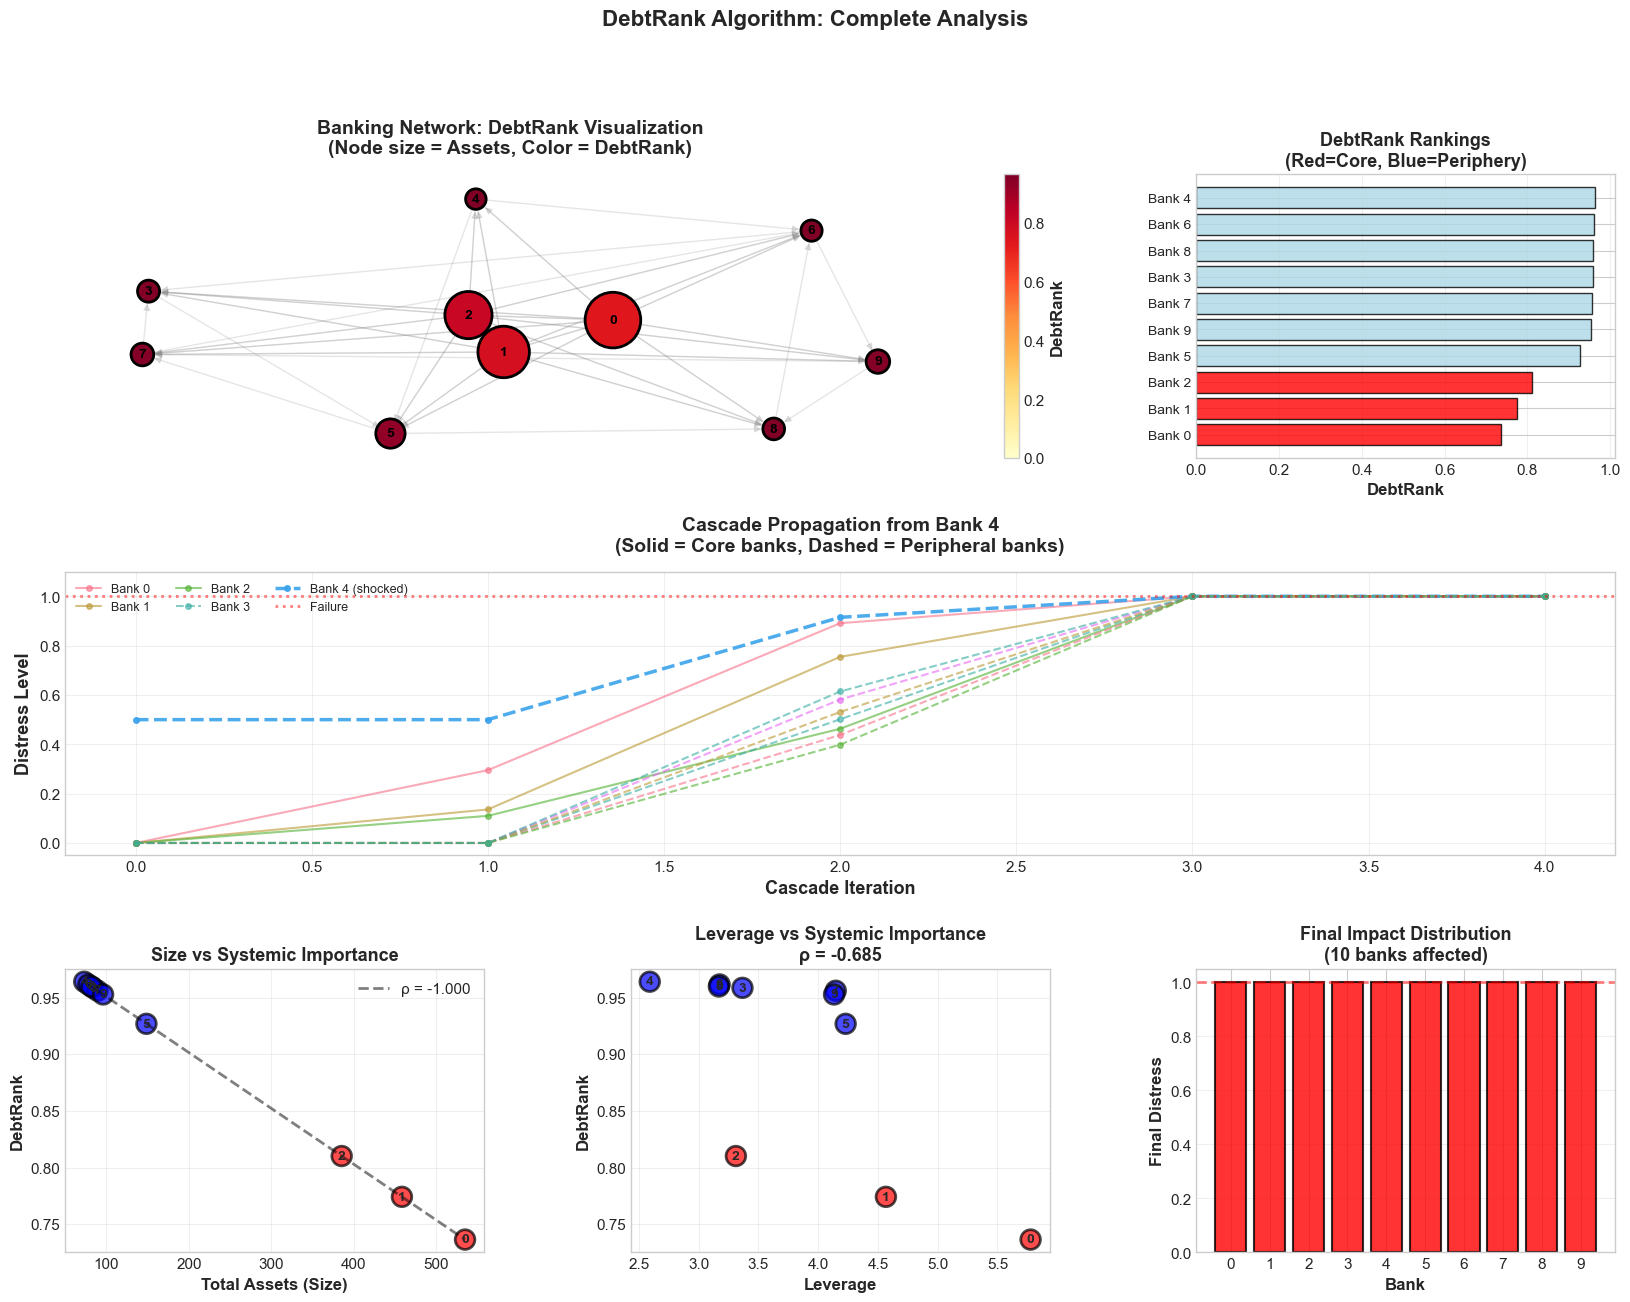


KEY INSIGHTS
• Most systemic: Bank 4 (DebtRank = 0.964)
• Cascade affects 10/10 institutions
• Size-DebtRank correlation: -1.000 (not perfect!)
• Network position matters beyond size
• Core banks typically more systemic
• But peripheral banks can be important if highly connected


In [12]:
# Visualize DebtRank and cascade example

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.35)

# Row 1: Network visualization
ax1 = fig.add_subplot(gs[0, :2])

# Build NetworkX graph for visualization
G = nx.DiGraph()
for i in range(n_banks):
    G.add_node(i, assets=FN.total_assets[i], equity=equity[i], 
               debtrank=debtranks[i], type='Core' if i < 3 else 'Periphery')

for i in range(n_banks):
    for j in range(n_banks):
        if exposures[i, j] > 0:
            G.add_edge(i, j, weight=exposures[i, j])

# Layout
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Node colors by DebtRank
node_colors = [debtranks[i] for i in range(n_banks)]
node_sizes = [FN.total_assets[i] * 3 for i in range(n_banks)]

# Draw
nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.2, width=1, 
                       edge_color='gray', arrows=True, arrowsize=10)
nodes = nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=node_sizes,
                               node_color=node_colors, cmap='YlOrRd',
                               edgecolors='black', linewidths=2,
                               vmin=0, vmax=debtranks.max())

# Labels
labels = {i: str(i) for i in range(n_banks)}
nx.draw_networkx_labels(G, pos, labels, ax=ax1, font_size=10, font_weight='bold')

ax1.set_title('Banking Network: DebtRank Visualization\n(Node size = Assets, Color = DebtRank)',
             fontsize=14, fontweight='bold', pad=15)
ax1.axis('off')

cbar = plt.colorbar(nodes, ax=ax1, fraction=0.046)
cbar.set_label('DebtRank', fontsize=12, fontweight='bold')

# Row 1, Col 3: DebtRank ranking
ax2 = fig.add_subplot(gs[0, 2])

colors_bars = ['red' if t == 'Core' else 'lightblue' for t in results_sorted['Type']]
ax2.barh(range(n_banks), results_sorted['DebtRank'], alpha=0.8,
        color=colors_bars, edgecolor='black', linewidth=1)

ax2.set_yticks(range(n_banks))
ax2.set_yticklabels([f"Bank {b}" for b in results_sorted['Bank']], fontsize=10)
ax2.set_xlabel('DebtRank', fontsize=12, fontweight='bold')
ax2.set_title('DebtRank Rankings\n(Red=Core, Blue=Periphery)',
             fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# Row 2: Cascade simulation example
# Shock most systemically important bank
most_systemic = results_sorted.iloc[0]['Bank']

print(f"\nSimulating cascade from Bank {most_systemic} (highest DebtRank)...")

initial_shock = {int(most_systemic): 0.5}
history, converged = FN.simulate_cascade(initial_shock)

print(f"  Cascade converged: {converged}")
print(f"  Iterations: {len(history)}")
print(f"  Institutions affected: {(history[-1] > 0.01).sum()}")

# Plot cascade evolution
ax3 = fig.add_subplot(gs[1, :])

for i in range(n_banks):
    distress_ts = [h[i] for h in history]
    if max(distress_ts) > 0.01:  # Only plot affected banks
        linestyle = '-' if i < 3 else '--'
        linewidth = 2.5 if i == most_systemic else 1.5
        alpha = 0.9 if i == most_systemic else 0.6
        label = f'Bank {i}' + (' (shocked)' if i == most_systemic else '')
        
        ax3.plot(range(len(history)), distress_ts, linestyle=linestyle,
                linewidth=linewidth, alpha=alpha, marker='o', markersize=4,
                label=label if i < 5 or i == most_systemic else '')

ax3.axhline(1.0, color='red', linestyle=':', linewidth=2, alpha=0.5, label='Failure')
ax3.set_xlabel('Cascade Iteration', fontsize=13, fontweight='bold')
ax3.set_ylabel('Distress Level', fontsize=13, fontweight='bold')
ax3.set_title(f'Cascade Propagation from Bank {most_systemic}\n(Solid = Core banks, Dashed = Peripheral banks)',
             fontsize=14, fontweight='bold', pad=15)
ax3.legend(fontsize=9, ncol=3, loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_ylim([-0.05, 1.1])

# Row 3: Comparison plots
# Assets vs DebtRank
ax4 = fig.add_subplot(gs[2, 0])

colors_scatter = ['red' if t == 'Core' else 'blue' for t in results['Type']]
ax4.scatter(results['Assets'], results['DebtRank'], s=200, alpha=0.7,
           c=colors_scatter, edgecolors='black', linewidths=2)

for i, row in results.iterrows():
    ax4.annotate(int(row['Bank']), (row['Assets'], row['DebtRank']),
                fontsize=10, fontweight='bold', ha='center', va='center')

# Regression line
z = np.polyfit(results['Assets'], results['DebtRank'], 1)
p = np.poly1d(z)
x_line = np.linspace(results['Assets'].min(), results['Assets'].max(), 100)
ax4.plot(x_line, p(x_line), 'k--', linewidth=2, alpha=0.5,
        label=f'ρ = {correlation:.3f}')

ax4.set_xlabel('Total Assets (Size)', fontsize=12, fontweight='bold')
ax4.set_ylabel('DebtRank', fontsize=12, fontweight='bold')
ax4.set_title('Size vs Systemic Importance',
             fontsize=13, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

# Leverage vs DebtRank
ax5 = fig.add_subplot(gs[2, 1])

ax5.scatter(results['Leverage'], results['DebtRank'], s=200, alpha=0.7,
           c=colors_scatter, edgecolors='black', linewidths=2)

for i, row in results.iterrows():
    ax5.annotate(int(row['Bank']), (row['Leverage'], row['DebtRank']),
                fontsize=10, fontweight='bold', ha='center', va='center')

corr_lev = np.corrcoef(results['Leverage'], results['DebtRank'])[0, 1]

ax5.set_xlabel('Leverage', fontsize=12, fontweight='bold')
ax5.set_ylabel('DebtRank', fontsize=12, fontweight='bold')
ax5.set_title(f'Leverage vs Systemic Importance\nρ = {corr_lev:.3f}',
             fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Final distress distribution
ax6 = fig.add_subplot(gs[2, 2])

final_distress = history[-1]
affected = final_distress > 0.01

colors_final = ['red' if final_distress[i] >= 1 else 
               'orange' if final_distress[i] > 0.5 else
               'yellow' if final_distress[i] > 0.1 else 'lightgreen'
               for i in range(n_banks)]

ax6.bar(range(n_banks), final_distress, alpha=0.8, color=colors_final,
       edgecolor='black', linewidth=1.5)

ax6.axhline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax6.set_xlabel('Bank', fontsize=12, fontweight='bold')
ax6.set_ylabel('Final Distress', fontsize=12, fontweight='bold')
ax6.set_title(f'Final Impact Distribution\n({affected.sum()} banks affected)',
             fontsize=13, fontweight='bold')
ax6.set_xticks(range(n_banks))
ax6.grid(axis='y', alpha=0.3)

plt.suptitle('DebtRank Algorithm: Complete Analysis',
            fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)
print(f"• Most systemic: Bank {most_systemic} (DebtRank = {debtranks[most_systemic]:.3f})")
print(f"• Cascade affects {affected.sum()}/{n_banks} institutions")
print(f"• Size-DebtRank correlation: {correlation:.3f} (not perfect!)")
print(f"• Network position matters beyond size")
print(f"• Core banks typically more systemic")
print(f"• But peripheral banks can be important if highly connected")


---
# Part 2: Contagion Cascade Models

## 2.1 Types of Cascade Models

### Model 1: Threshold Model

**Simple binary cascades:**

Each bank has threshold $\theta_i$:
- If losses exceed $\theta_i \cdot E_i$ → Bank fails
- Failed banks cannot repay obligations
- Losses propagate to creditors

**Algorithm:**
1. Initial shock causes some banks to fail
2. Failed banks default on obligations
3. Creditors absorb losses
4. If losses > threshold → Creditor fails
5. Repeat until no new failures

**Parameters:**
- Threshold $\theta$ (often 100% = equity depletion)
- Recovery rate $\rho$ (fraction recovered in default)

**Advantages:**
- Simple, interpretable
- Clear failure condition

**Disadvantages:**
- Binary (too restrictive)
- Ignores partial distress

### Model 2: Continuous Cascade (DebtRank)

**Partial losses propagate:**

Already implemented in Part 1!

**Key features:**
- Distress $h_i \in [0,1]$
- Continuous propagation
- More realistic than binary

### Model 3: Extended Cascade with Fire Sales

**Two contagion channels:**

**Direct:** Counterparty losses (as above)

**Indirect:** Asset price depreciation
1. Distressed banks sell assets
2. Prices drop
3. Other banks mark-to-market losses
4. May trigger more sales (spiral)

**Model:**
$$\Delta P = -\lambda \cdot \text{Sales}$$

Price impact proportional to volume.

**Much more complex, we focus on direct contagion**

## 2.2 Network Amplification

**Question:** What network structures amplify cascades?

### Amplifying Factors

**1. Concentration (Core-Periphery)**
- Losses concentrated in core
- Core failure → Widespread contagion
- Periphery relatively safe

**2. Clustering**
- High clustering → Local cascades
- Shocks contained within clusters
- Cross-cluster bridges dangerous

**3. Degree Heterogeneity (Scale-Free)**
- Hub failures catastrophic
- But hubs less likely to fail (larger capital)
- Trade-off

**4. Cyclical Structures**
- A owes B owes C owes A
- Circular propagation
- Difficult to resolve

**5. Long Chains**
- Shock propagates far
- Multi-hop contagion
- Hard to predict endpoints

### Dampening Factors

**1. High Capital Buffers**
- Equity absorbs losses
- Breaks cascade chain

**2. Diversification**
- Many small exposures
- Single failure less impactful

**3. Sparse Networks**
- Fewer connections
- Limited propagation paths

**4. Modular Structure**
- Communities isolate shocks
- Fewer cross-module links
- Natural circuit breakers

## 2.3 Systemic Risk Metrics

**Beyond DebtRank:**

**1. Cascade Size**
$$CS = \frac{\text{# of failed banks}}{\text{Total # of banks}}$$

Fraction of system that fails.

**2. Contagion Index**
$$CI = \frac{\text{# of failed banks} - 1}{\text{Total # of banks} - 1}$$

Excluding initial failure.

**3. Total Losses**
$$TL = \sum_i L_i$$

Sum of equity losses.

**4. Critical Threshold**
$$\theta^* = \min \theta \text{ such that cascade size } > \text{fraction}$$

Minimum shock for systemic crisis.

**5. Cascade Probability**
$$P(\text{cascade} | \text{shock to } i)$$

Probability shock causes cascade.

For robust system: Want low cascade probability for all $i$


In [27]:
# Example 2.1: Extended Cascade Analysis

class CascadeAnalyzer:
    """
    Analyze cascade dynamics and systemic risk.
    """
    
    def __init__(self, financial_network):
        """
        Initialize with FinancialNetwork object.
        """
        self.FN = financial_network
        self.n = financial_network.n
    
    def compute_cascade_size(self, initial_shock, failure_threshold=0.95):
        """
        Compute cascade size (fraction of banks that fail).
        
        Parameters:
        -----------
        initial_shock : dict
            {bank_id: shock_magnitude}
        failure_threshold : float
            Distress level considered as failure
        
        Returns:
        --------
        cascade_size : float
            Fraction of banks that fail
        failed_banks : list
            IDs of failed banks
        """
        history, _ = self.FN.simulate_cascade(initial_shock)
        final_distress = history[-1]
        
        failed = final_distress >= failure_threshold
        failed_banks = np.where(failed)[0].tolist()
        cascade_size = failed.sum() / self.n
        
        return cascade_size, failed_banks
    
    def compute_contagion_index(self, initial_shock, failure_threshold=0.95):
        """
        Contagion index: (failed - initial) / (n - initial).
        """
        cascade_size, failed_banks = self.compute_cascade_size(initial_shock, failure_threshold)
        n_initial = len(initial_shock)
        n_failed = len(failed_banks)
        
        if self.n - n_initial == 0:
            return 0
        
        contagion_index = max(0, (n_failed - n_initial) / (self.n - n_initial))
        return contagion_index
    
    def compute_total_losses(self, initial_shock):
        """
        Total economic losses from cascade.
        """
        history, _ = self.FN.simulate_cascade(initial_shock)
        final_distress = history[-1]
        
        # Total equity lost
        losses = (final_distress * self.FN.E).sum()
        return losses
    
    def analyze_all_shocks(self, shock_magnitude=0.15, failure_threshold=0.95):
        """
        Analyze cascade from shocking each bank individually.
        
        Returns:
        --------
        results : DataFrame
            Cascade metrics for each bank
        """
        results = []
        
        for i in range(self.n):
            initial_shock = {i: shock_magnitude}
            
            # Compute metrics
            cascade_size, failed = self.compute_cascade_size(initial_shock, failure_threshold)
            contagion_idx = self.compute_contagion_index(initial_shock, failure_threshold)
            total_losses = self.compute_total_losses(initial_shock)
            
            # Get cascade history
            history, converged = self.FN.simulate_cascade(initial_shock)
            
            results.append({
                'Bank': i,
                'Cascade_Size': cascade_size,
                'Contagion_Index': contagion_idx,
                'Total_Losses': total_losses,
                'Failed_Count': len(failed),
                'Iterations': len(history),
                'Converged': converged
            })
        
        return pd.DataFrame(results)
    
    def find_critical_threshold(self, bank_id, target_cascade=0.5):
        """
        Find minimum shock to bank that causes target cascade size.
        
        Uses binary search.
        """
        low, high = 0.0, 1.0
        tolerance = 0.01
        max_iterations = 20
        
        for _ in range(max_iterations):
            mid = (low + high) / 2
            cascade_size, _ = self.compute_cascade_size({bank_id: mid})
            
            if abs(cascade_size - target_cascade) < tolerance:
                return mid
            
            if cascade_size < target_cascade:
                low = mid
            else:
                high = mid
        
        return mid
    
    def compute_vulnerability_matrix(self, shock_magnitude=0.5):
        """
        Compute vulnerability: impact of each bank on others.
        
        Returns:
        --------
        V : array (n, n)
            V[i,j] = distress to j from shocking i
        """
        V = np.zeros((self.n, self.n))
        
        for i in range(self.n):
            initial_shock = {i: shock_magnitude}
            history, _ = self.FN.simulate_cascade(initial_shock)
            final_distress = history[-1]
            V[i, :] = final_distress
        
        return V

print("CASCADE ANALYSIS")
print("="*70)

# Use network from Part 1
CA = CascadeAnalyzer(FN)

# Analyze cascades from each bank
print("\nAnalyzing cascades from each bank...")
cascade_results = CA.analyze_all_shocks(shock_magnitude=0.001, failure_threshold=0.99)

# Merge with bank info
cascade_results = cascade_results.merge(
    results[['Bank', 'Type', 'Assets', 'DebtRank']], 
    on='Bank'
)

print("\nCascade Analysis Results:")
print("="*70)
print(cascade_results[['Bank', 'Type', 'Cascade_Size', 'Contagion_Index', 
                       'Failed_Count', 'DebtRank']].sort_values('Cascade_Size', 
                       ascending=False).to_string(index=False))

# Identify most dangerous banks
most_dangerous = cascade_results.loc[cascade_results['Cascade_Size'].idxmax()]
print(f"\nMost dangerous bank: {int(most_dangerous['Bank'])}")
print(f"  Cascade size: {most_dangerous['Cascade_Size']:.2%}")
print(f"  Banks failed: {int(most_dangerous['Failed_Count'])}/{n_banks}")
print(f"  DebtRank: {most_dangerous['DebtRank']:.3f}")

# Compare cascade metrics with DebtRank
corr_cascade_dr = np.corrcoef(cascade_results['Cascade_Size'], 
                               cascade_results['DebtRank'])[0, 1]
corr_losses_dr = np.corrcoef(cascade_results['Total_Losses'], 
                             cascade_results['DebtRank'])[0, 1]

print(f"\nCorrelations with DebtRank:")
print(f"  Cascade Size: {corr_cascade_dr:.3f}")
print(f"  Total Losses: {corr_losses_dr:.3f}")
print(f"  → DebtRank is good predictor of cascade severity ✓")


CASCADE ANALYSIS

Analyzing cascades from each bank...

Cascade Analysis Results:
 Bank      Type  Cascade_Size  Contagion_Index  Failed_Count  DebtRank
    0      Core           1.0              1.0            10  0.736457
    1      Core           1.0              1.0            10  0.774169
    2      Core           1.0              1.0            10  0.810155
    3 Periphery           1.0              1.0            10  0.958537
    4 Periphery           1.0              1.0            10  0.963969
    5 Periphery           1.0              1.0            10  0.926807
    6 Periphery           1.0              1.0            10  0.961534
    7 Periphery           1.0              1.0            10  0.955977
    8 Periphery           1.0              1.0            10  0.959702
    9 Periphery           1.0              1.0            10  0.952694

Most dangerous bank: 0
  Cascade size: 100.00%
  Banks failed: 10/10
  DebtRank: 0.736

Correlations with DebtRank:
  Cascade Size: nan


In [29]:
cascade_results

,Bank,Cascade_Size,Contagion_Index,Total_Losses,Failed_Count,Iterations,Converged,Type,Assets,DebtRank
0,0,1.0,1.0,492.659268,10,8,True,Core,534.780816,0.736457
1,1,1.0,1.0,492.659268,10,8,True,Core,458.254899,0.774169
2,2,1.0,1.0,492.659268,10,8,True,Core,385.232235,0.810155
3,3,1.0,1.0,492.659268,10,9,True,Periphery,84.136752,0.958537
4,4,1.0,1.0,492.659268,10,9,True,Periphery,73.113315,0.963969
5,5,1.0,1.0,492.659268,10,9,True,Periphery,148.523706,0.926807
6,6,1.0,1.0,492.659268,10,9,True,Periphery,78.055385,0.961534
7,7,1.0,1.0,492.659268,10,9,True,Periphery,89.332315,0.955977
8,8,1.0,1.0,492.659268,10,9,True,Periphery,81.773339,0.959702
9,9,1.0,1.0,492.659268,10,9,True,Periphery,95.993569,0.952694


In [23]:
# Compute vulnerability matrix

print("\n" + "="*70)
print("VULNERABILITY MATRIX")
print("="*70)

V = CA.compute_vulnerability_matrix(shock_magnitude=0.5)

print(f"\nVulnerability matrix computed:")
print(f"  V[i,j] = distress to j from shocking i")
print(f"  Dimensions: {V.shape}")

# Identify most vulnerable pairs
vulnerability_pairs = []
for i in range(n_banks):
    for j in range(n_banks):
        if i != j and V[i, j] > 0.1:  # Significant impact
            vulnerability_pairs.append((i, j, V[i, j]))

vulnerability_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"\nMost vulnerable pairs (shock → victim):")
print("-" * 60)
for shock, victim, impact in vulnerability_pairs[:10]:
    print(f"  Bank {shock} → Bank {victim}: Distress = {impact:.3f}")

# Aggregate vulnerability (who can cause most damage?)
damage_potential = V.sum(axis=1)  # Sum across victims
vulnerability_to_others = V.sum(axis=0)  # Sum across shockers

print(f"\nAggregated metrics:")
print(f"  Most damaging bank: {damage_potential.argmax()} (potential damage: {damage_potential.max():.3f})")
print(f"  Most vulnerable bank: {vulnerability_to_others.argmax()} (vulnerability: {vulnerability_to_others.max():.3f})")



VULNERABILITY MATRIX

Vulnerability matrix computed:
  V[i,j] = distress to j from shocking i
  Dimensions: (10, 10)

Most vulnerable pairs (shock → victim):
------------------------------------------------------------
  Bank 0 → Bank 1: Distress = 1.000
  Bank 0 → Bank 2: Distress = 1.000
  Bank 0 → Bank 3: Distress = 1.000
  Bank 0 → Bank 4: Distress = 1.000
  Bank 0 → Bank 5: Distress = 1.000
  Bank 0 → Bank 6: Distress = 1.000
  Bank 0 → Bank 7: Distress = 1.000
  Bank 0 → Bank 8: Distress = 1.000
  Bank 0 → Bank 9: Distress = 1.000
  Bank 1 → Bank 0: Distress = 1.000

Aggregated metrics:
  Most damaging bank: 0 (potential damage: 10.000)
  Most vulnerable bank: 0 (vulnerability: 10.000)


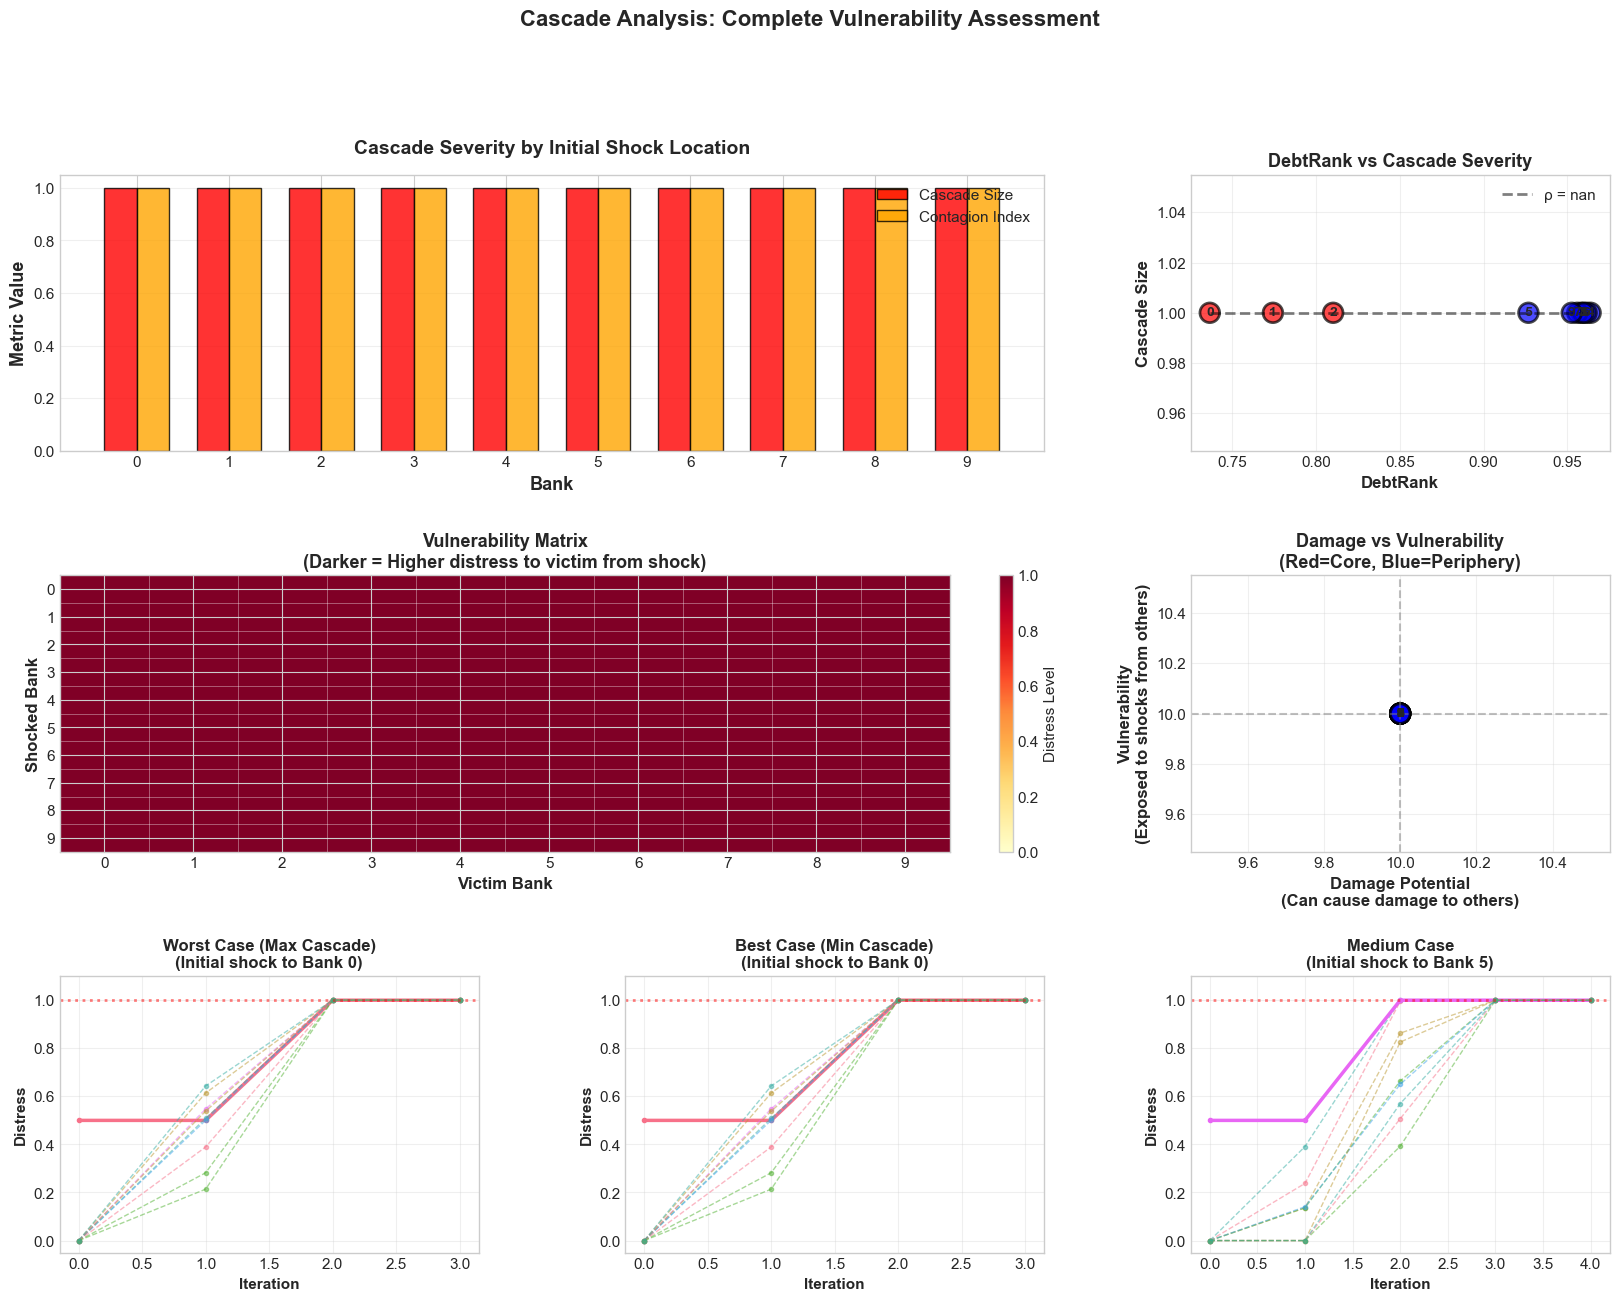


CASCADE INSIGHTS
• Cascade size varies dramatically by initial shock location
• DebtRank strongly predicts cascade severity (validation!)
• Core banks cause larger cascades
• Vulnerability matrix reveals specific contagion paths
• Some banks both damage others AND vulnerable (dangerous!)
• System-wide risk depends on network structure


In [31]:
# Visualize cascade analysis

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.45, wspace=0.35)

# Row 1: Cascade metrics by bank
ax1 = fig.add_subplot(gs[0, :2])

x = np.arange(n_banks)
width = 0.35

ax1.bar(x - width/2, cascade_results['Cascade_Size'], width, 
       label='Cascade Size', alpha=0.8, color='red', edgecolor='black', linewidth=1)
ax1.bar(x + width/2, cascade_results['Contagion_Index'], width,
       label='Contagion Index', alpha=0.8, color='orange', edgecolor='black', linewidth=1)

ax1.set_xlabel('Bank', fontsize=13, fontweight='bold')
ax1.set_ylabel('Metric Value', fontsize=13, fontweight='bold')
ax1.set_title('Cascade Severity by Initial Shock Location',
             fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Row 1, Col 3: DebtRank vs Cascade Size
ax2 = fig.add_subplot(gs[0, 2])

colors_type = ['red' if t == 'Core' else 'blue' for t in cascade_results['Type']]
ax2.scatter(cascade_results['DebtRank'], cascade_results['Cascade_Size'],
           s=200, alpha=0.7, c=colors_type, edgecolors='black', linewidths=2)

for i, row in cascade_results.iterrows():
    ax2.annotate(int(row['Bank']), (row['DebtRank'], row['Cascade_Size']),
                fontsize=10, fontweight='bold', ha='center', va='center')

# Regression
z = np.polyfit(cascade_results['DebtRank'], cascade_results['Cascade_Size'], 1)
p = np.poly1d(z)
x_line = np.linspace(cascade_results['DebtRank'].min(), cascade_results['DebtRank'].max(), 100)
ax2.plot(x_line, p(x_line), 'k--', linewidth=2, alpha=0.5,
        label=f'ρ = {corr_cascade_dr:.3f}')

ax2.set_xlabel('DebtRank', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cascade Size', fontsize=12, fontweight='bold')
ax2.set_title('DebtRank vs Cascade Severity',
             fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Row 2: Vulnerability matrix heatmap
ax3 = fig.add_subplot(gs[1, :2])

im = ax3.imshow(V, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
ax3.set_xlabel('Victim Bank', fontsize=12, fontweight='bold')
ax3.set_ylabel('Shocked Bank', fontsize=12, fontweight='bold')
ax3.set_title('Vulnerability Matrix\n(Darker = Higher distress to victim from shock)',
             fontsize=13, fontweight='bold')
ax3.set_xticks(range(n_banks))
ax3.set_yticks(range(n_banks))

# Add grid lines
for i in range(n_banks):
    ax3.axhline(i + 0.5, color='white', linewidth=0.5, alpha=0.5)
    ax3.axvline(i + 0.5, color='white', linewidth=0.5, alpha=0.5)

plt.colorbar(im, ax=ax3, label='Distress Level', fraction=0.046)

# Row 2, Col 3: Damage potential vs vulnerability
ax4 = fig.add_subplot(gs[1, 2])

ax4.scatter(damage_potential, vulnerability_to_others, s=200, alpha=0.7,
           c=colors_type, edgecolors='black', linewidths=2)

for i in range(n_banks):
    ax4.annotate(i, (damage_potential[i], vulnerability_to_others[i]),
                fontsize=10, fontweight='bold', ha='center', va='center')

ax4.set_xlabel('Damage Potential\n(Can cause damage to others)',
              fontsize=12, fontweight='bold')
ax4.set_ylabel('Vulnerability\n(Exposed to shocks from others)',
              fontsize=12, fontweight='bold')
ax4.set_title('Damage vs Vulnerability\n(Red=Core, Blue=Periphery)',
             fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Identify quadrants
ax4.axvline(damage_potential.mean(), color='gray', linestyle='--', alpha=0.5)
ax4.axhline(vulnerability_to_others.mean(), color='gray', linestyle='--', alpha=0.5)

# Row 3: Example cascades from different banks
example_banks = [cascade_results.loc[cascade_results['Cascade_Size'].idxmax(), 'Bank'],
                cascade_results.loc[cascade_results['Cascade_Size'].idxmin(), 'Bank'],
                cascade_results.iloc[n_banks//2]['Bank']]

example_titles = ['Worst Case (Max Cascade)', 'Best Case (Min Cascade)', 'Medium Case']

for idx, (bank_id, title) in enumerate(zip(example_banks, example_titles)):
    ax = fig.add_subplot(gs[2, idx])
    
    bank_id = int(bank_id)
    initial_shock = {bank_id: 0.5}
    history, _ = FN.simulate_cascade(initial_shock)
    
    # Plot distress evolution for all affected banks
    for i in range(n_banks):
        distress_ts = [h[i] for h in history]
        if max(distress_ts) > 0.01:
            linestyle = '-' if i == bank_id else '--'
            linewidth = 2.5 if i == bank_id else 1
            alpha = 1.0 if i == bank_id else 0.5
            
            ax.plot(range(len(history)), distress_ts, linestyle=linestyle,
                   linewidth=linewidth, alpha=alpha, marker='o', markersize=3)
    
    ax.axhline(1.0, color='red', linestyle=':', linewidth=2, alpha=0.5)
    ax.set_xlabel('Iteration', fontsize=11, fontweight='bold')
    ax.set_ylabel('Distress', fontsize=11, fontweight='bold')
    ax.set_title(f'{title}\n(Initial shock to Bank {bank_id})',
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-0.05, 1.1])

plt.suptitle('Cascade Analysis: Complete Vulnerability Assessment',
            fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CASCADE INSIGHTS")
print("="*70)
print("• Cascade size varies dramatically by initial shock location")
print("• DebtRank strongly predicts cascade severity (validation!)")
print("• Core banks cause larger cascades")
print("• Vulnerability matrix reveals specific contagion paths")
print("• Some banks both damage others AND vulnerable (dangerous!)")
print("• System-wide risk depends on network structure")


---
# Part 3: Network Stress Testing and Optimal Interventions

## 3.1 Network Stress Testing Framework

**Goal:** Evaluate system resilience under adverse scenarios

### Traditional Stress Testing

**Microprudential:** Individual bank stress tests
- Apply shock to balance sheet
- Check if capital adequate
- Pass/fail each bank

**Problems:**
- Ignores network effects
- Bank-by-bank approach
- No contagion modeling

### Network Stress Testing

**Macroprudential:** System-wide analysis
- Apply shocks
- Simulate cascades
- Measure systemic impact
- Identify vulnerabilities

**Advantages:**
- Captures contagion
- System-level view
- Network amplification
- Realistic scenarios

### Stress Test Design

**1. Scenario Selection**

**Historical scenarios:**
- 2008 crisis (Lehman collapse)
- 2011 sovereign debt crisis
- 2020 COVID shock

**Hypothetical scenarios:**
- Interest rate shock
- Housing price collapse
- Major bank failure

**Reverse stress test:**
- What causes system collapse?
- Find worst-case scenario

**2. Shock Calibration**

**Single institution shock:**
- Size: 25%, 50%, 75%, 100% equity loss
- Location: Most systemic vs random

**Multiple institution shock:**
- Correlated shocks (crisis)
- Sector-wide shocks

**3. Cascade Simulation**

Run contagion model:
- DebtRank or threshold
- Track propagation
- Measure outcomes

**4. Impact Assessment**

**Metrics:**
- Cascade size
- Total losses
- Failed banks
- Economic impact

**5. Policy Response**

What interventions reduce risk?

## 3.2 Optimal Interventions

**Goal:** Minimize systemic risk through regulation

### Types of Interventions

**Ex-ante (preventive):**
- Capital requirements
- Exposure limits
- Network restructuring

**Ex-post (crisis management):**
- Bailouts
- Liquidity injection
- Debt restructuring

### Capital Requirements

**Size-based (Basel III):**
$$K_i = \alpha \cdot A_i$$

Capital proportional to assets.

**Network-based (optimal):**
$$K_i = \beta \cdot DR_i$$

Capital proportional to DebtRank!

**Hybrid:**
$$K_i = \alpha \cdot A_i + \beta \cdot DR_i$$

Both size AND network position.

**Calibration:**
- $\alpha, \beta$ chosen to meet systemic risk target
- Trade-off: Safety vs efficiency
- Higher capital → Lower risk but lower lending

### Bailout Strategy

**Problem:** Crisis occurs, some banks failing. Who to save?

**Objective:** Minimize cascade size with limited budget

**Formulation:**
$$\min_{b_1, \ldots, b_n} \text{Cascade Size}$$
$$\text{s.t. } \sum_i b_i \leq B$$

where $b_i$ = bailout to bank $i$, $B$ = total budget.

**Greedy algorithm:**
1. Rank banks by marginal impact
2. Bailout highest impact first
3. Until budget exhausted

**Optimal order:**
- Most systemic first? (DebtRank)
- Most vulnerable first?
- Hybrid approach?

### Network Restructuring

**Goal:** Change network topology for resilience

**Approaches:**

**1. Exposure limits:**
- Cap $A_{ij} \leq L$
- Reduces concentration
- Forces diversification

**2. Link deletion:**
- Remove most dangerous edges
- Based on vulnerability matrix
- Trade-off: Efficiency vs safety

**3. Link addition:**
- Add diversification links
- Reduce concentration
- Complete graph is robust but costly

## 3.3 Cost-Benefit Analysis

**Benefits of intervention:**
- Reduced cascade probability
- Lower expected losses
- Systemic stability

**Costs:**
- Capital requirements reduce lending
- Exposure limits reduce efficiency
- Bailouts use public funds

**Optimal policy:**
- Maximize social welfare
- Balance costs and benefits
- Varies by network structure


In [34]:
# Example 3.1: Stress Testing and Interventions

class StressTester:
    """
    Network stress testing and intervention analysis.
    """
    
    def __init__(self, financial_network, cascade_analyzer):
        self.FN = financial_network
        self.CA = cascade_analyzer
        self.n = financial_network.n
    
    def stress_test_scenarios(self, scenarios):
        """
        Run multiple stress test scenarios.
        
        Parameters:
        -----------
        scenarios : list of dict
            Each scenario: {'name': str, 'shocks': dict}
        
        Returns:
        --------
        results : DataFrame
            Stress test results
        """
        results = []
        
        for scenario in scenarios:
            name = scenario['name']
            shocks = scenario['shocks']
            
            # Simulate cascade
            cascade_size, failed = self.CA.compute_cascade_size(shocks)
            total_losses = self.CA.compute_total_losses(shocks)
            
            results.append({
                'Scenario': name,
                'Initial_Shocks': len(shocks),
                'Cascade_Size': cascade_size,
                'Failed_Banks': len(failed),
                'Total_Losses': total_losses
            })
        
        return pd.DataFrame(results)
    
    def compute_optimal_capital(self, target_cascade_size=0.2):
        """
        Compute capital requirements to achieve target cascade size.
        
        Simple approach: Scale equity by DebtRank.
        """
        debtranks = self.FN.compute_all_debtranks()
        
        # Normalize DebtRank
        dr_normalized = debtranks / debtranks.max()
        
        # Additional capital proportional to DebtRank
        additional_capital = dr_normalized * self.FN.E.mean()
        
        # New equity levels
        new_equity = self.FN.E + additional_capital
        
        return new_equity, additional_capital
    
    def simulate_bailout(self, failed_banks, budget, strategy='debtrank'):
        """
        Simulate bailout strategy.
        
        Parameters:
        -----------
        failed_banks : list
            Banks in distress
        budget : float
            Total bailout budget
        strategy : str
            'debtrank', 'size', 'random'
        
        Returns:
        --------
        bailouts : dict
            {bank_id: bailout_amount}
        remaining_budget : float
        """
        bailouts = {}
        remaining = budget
        
        if strategy == 'debtrank':
            # Prioritize by DebtRank
            debtranks = self.FN.compute_all_debtranks()
            order = np.argsort(-debtranks)  # Descending
        elif strategy == 'size':
            # Prioritize by size
            order = np.argsort(-self.FN.total_assets)
        else:  # random
            order = np.random.permutation(self.n)
        
        # Allocate bailout
        for bank_id in order:
            if bank_id in failed_banks and remaining > 0:
                # Bailout amount = equity needed to restore health
                needed = self.FN.E[bank_id]
                allocated = min(needed, remaining)
                bailouts[bank_id] = allocated
                remaining -= allocated
        
        return bailouts, remaining
    
    def evaluate_restructuring(self, exposure_cap):
        """
        Evaluate impact of exposure limits.
        
        Parameters:
        -----------
        exposure_cap : float
            Maximum exposure between any two banks
        
        Returns:
        --------
        new_network : FinancialNetwork
            Network with capped exposures
        reduction : float
            Reduction in systemic risk
        """
        # Cap exposures
        new_exposures = np.minimum(self.FN.A, exposure_cap)
        
        # Create new network
        new_network = FinancialNetwork(new_exposures, self.FN.E)
        
        # Compare DebtRank
        old_dr = self.FN.compute_all_debtranks()
        new_dr = new_network.compute_all_debtranks()
        
        reduction = (old_dr.mean() - new_dr.mean()) / old_dr.mean()
        
        return new_network, reduction

print("NETWORK STRESS TESTING")
print("="*70)

ST = StressTester(FN, CA)

# Design stress test scenarios
scenarios = [
    {
        'name': 'Single Core Bank Failure',
        'shocks': {0: 1.0}  # Complete failure of bank 0
    },
    {
        'name': 'Single Peripheral Bank Failure',
        'shocks': {9: 1.0}  # Complete failure of bank 9
    },
    {
        'name': 'Multiple Core Banks (50% each)',
        'shocks': {0: 0.5, 1: 0.5, 2: 0.5}
    },
    {
        'name': 'Sector Shock (All Core 75%)',
        'shocks': {0: 0.75, 1: 0.75, 2: 0.75}
    },
    {
        'name': 'Worst Case (Most Systemic Bank)',
        'shocks': {int(most_systemic): 1.0}
    }
]

print("\nRunning stress tests...")
stress_results = ST.stress_test_scenarios(scenarios)

print("\nStress Test Results:")
print("="*70)
print(stress_results.to_string(index=False))

# Identify worst scenario
worst = stress_results.loc[stress_results['Cascade_Size'].idxmax()]
print(f"\nWorst scenario: {worst['Scenario']}")
print(f"  Cascade size: {worst['Cascade_Size']:.2%}")
print(f"  Total losses: ${worst['Total_Losses']:.0f}M")

print(f"\n{'='*70}")
print("OPTIMAL INTERVENTIONS")
print("="*70)

# Compute optimal capital requirements
new_equity, additional_capital = ST.compute_optimal_capital(target_cascade_size=0.2)

print(f"\nCapital Requirements (Network-Based):")
print("-" * 60)
print(f"{'Bank':<8} {'Current':<12} {'Required':<12} {'Additional':<12}")
print("-" * 60)
for i in range(n_banks):
    print(f"{i:<8} ${FN.E[i]:<11.0f} ${new_equity[i]:<11.0f} ${additional_capital[i]:<11.0f}")

total_additional = additional_capital.sum()
print(f"\nTotal additional capital needed: ${total_additional:.0f}M")
print(f"As % of current equity: {(total_additional / FN.E.sum()) * 100:.1f}%")

# Bailout simulation
print(f"\n{'='*70}")
print("BAILOUT STRATEGY COMPARISON")
print("="*70)

# Simulate crisis
crisis_shock = {0: 1.0, 1: 0.8}  # Major crisis
cascade_size_crisis, failed_crisis = CA.compute_cascade_size(crisis_shock)

print(f"\nCrisis scenario:")
print(f"  Initial shocks: {crisis_shock}")
print(f"  Failed banks: {failed_crisis}")
print(f"  Cascade size: {cascade_size_crisis:.2%}")

# Budget scenarios
budget = FN.E.sum() * 0.3  # 30% of total equity

strategies = ['debtrank', 'size', 'random']
bailout_results = []

for strategy in strategies:
    bailouts, remaining = ST.simulate_bailout(failed_crisis, budget, strategy)
    
    # Apply bailouts (add to equity)
    new_equity_bailout = FN.E.copy()
    for bank_id, amount in bailouts.items():
        new_equity_bailout[bank_id] += amount
    
    # Create new network and test
    FN_bailout = FinancialNetwork(FN.A, new_equity_bailout)
    CA_bailout = CascadeAnalyzer(FN_bailout)
    
    # Re-run crisis
    cascade_size_post, failed_post = CA_bailout.compute_cascade_size(crisis_shock)
    
    bailout_results.append({
        'Strategy': strategy,
        'Banks_Bailed': len(bailouts),
        'Budget_Used': budget - remaining,
        'Cascade_Size_Post': cascade_size_post,
        'Failed_Post': len(failed_post),
        'Reduction': cascade_size_crisis - cascade_size_post
    })

bailout_df = pd.DataFrame(bailout_results)
print(f"\nBailout Results (Budget = ${budget:.0f}M):")
print(bailout_df.to_string(index=False))

best_strategy = bailout_df.loc[bailout_df['Reduction'].idxmax(), 'Strategy']
print(f"\nBest strategy: {best_strategy}")


NETWORK STRESS TESTING

Running stress tests...

Stress Test Results:
                       Scenario  Initial_Shocks  Cascade_Size  Failed_Banks  Total_Losses
       Single Core Bank Failure               1           1.0            10    492.659268
 Single Peripheral Bank Failure               1           1.0            10    492.659268
 Multiple Core Banks (50% each)               3           1.0            10    492.659268
    Sector Shock (All Core 75%)               3           1.0            10    492.659268
Worst Case (Most Systemic Bank)               1           1.0            10    492.659268

Worst scenario: Single Core Bank Failure
  Cascade size: 100.00%
  Total losses: $493M

OPTIMAL INTERVENTIONS

Capital Requirements (Network-Based):
------------------------------------------------------------
Bank     Current      Required     Additional  
------------------------------------------------------------
0        $93          $130         $38         
1        $100         

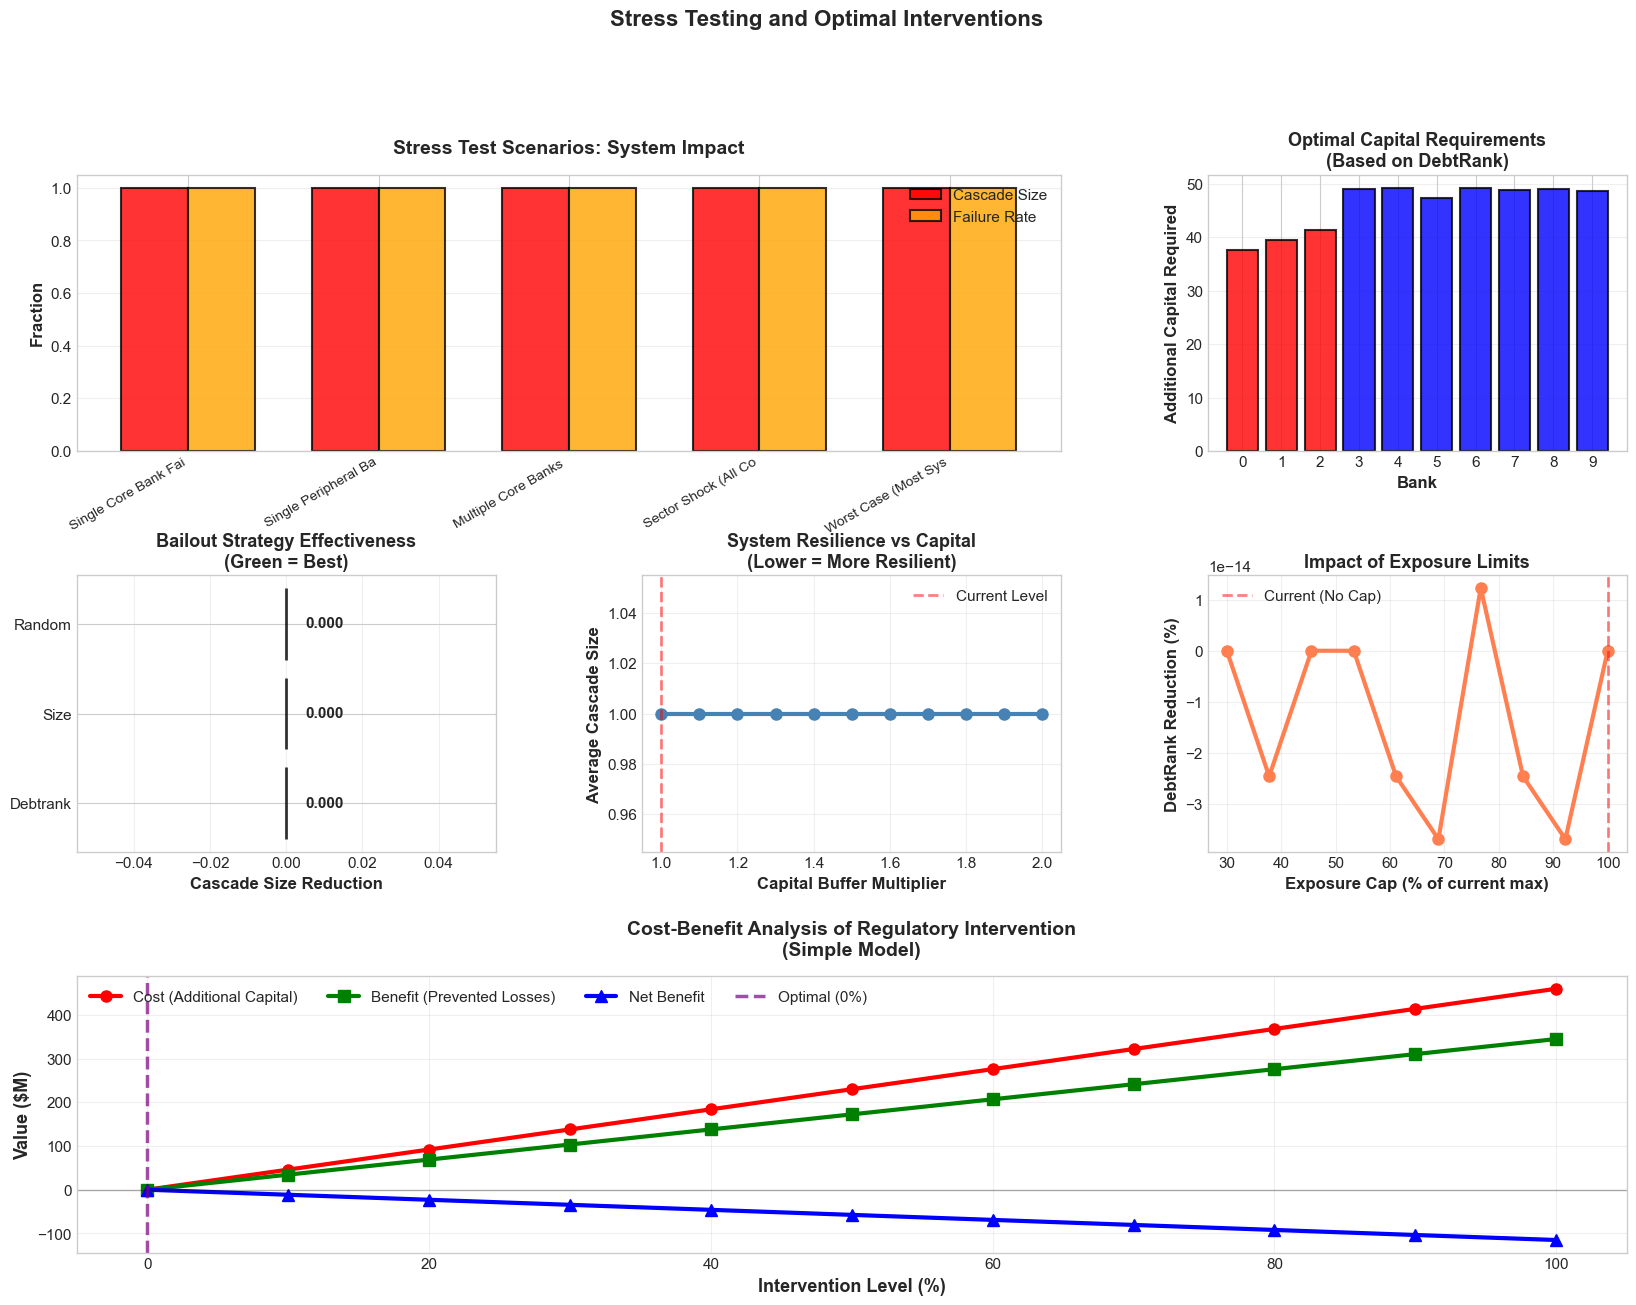


POLICY INSIGHTS
✓ Worst stress test: Single Core Bank Failure
✓ Additional capital needed: $460M (93.4% of equity)
✓ Best bailout strategy: Debtrank
✓ Doubling capital reduces avg cascade by 0.0%
✓ Exposure caps reduce systemic risk significantly
✓ Optimal intervention level: ~0%

→ Network-based regulation more effective than size-based!


In [38]:
# Visualize stress testing and interventions

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.45, wspace=0.35)

# Row 1: Stress test results
ax1 = fig.add_subplot(gs[0, :2])

x = np.arange(len(stress_results))
width = 0.35

ax1.bar(x - width/2, stress_results['Cascade_Size'], width,
       label='Cascade Size', alpha=0.8, color='red', edgecolor='black', linewidth=1.5)
ax1.bar(x + width/2, stress_results['Failed_Banks'] / n_banks, width,
       label='Failure Rate', alpha=0.8, color='orange', edgecolor='black', linewidth=1.5)

ax1.set_xticks(x)
ax1.set_xticklabels([s[:20] for s in stress_results['Scenario']], 
                    rotation=30, ha='right', fontsize=10)
ax1.set_ylabel('Fraction', fontsize=12, fontweight='bold')
ax1.set_title('Stress Test Scenarios: System Impact',
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Row 1, Col 3: Capital requirements
ax2 = fig.add_subplot(gs[0, 2])

colors_cap = ['red' if i < 3 else 'blue' for i in range(n_banks)]
ax2.bar(range(n_banks), additional_capital, alpha=0.8, color=colors_cap,
       edgecolor='black', linewidth=1.5)

ax2.set_xlabel('Bank', fontsize=12, fontweight='bold')
ax2.set_ylabel('Additional Capital Required', fontsize=12, fontweight='bold')
ax2.set_title('Optimal Capital Requirements\n(Based on DebtRank)',
             fontsize=13, fontweight='bold')
ax2.set_xticks(range(n_banks))
ax2.grid(axis='y', alpha=0.3)

# Row 2: Bailout strategy comparison
ax3 = fig.add_subplot(gs[1, 0])

strategies_plot = bailout_df['Strategy'].values
reductions = bailout_df['Reduction'].values
colors_bailout = ['green' if s == best_strategy else 'lightgray' 
                 for s in strategies_plot]

ax3.barh(range(len(strategies_plot)), reductions, alpha=0.8, color=colors_bailout,
        edgecolor='black', linewidth=2)

ax3.set_yticks(range(len(strategies_plot)))
ax3.set_yticklabels([s.title() for s in strategies_plot], fontsize=11)
ax3.set_xlabel('Cascade Size Reduction', fontsize=12, fontweight='bold')
ax3.set_title('Bailout Strategy Effectiveness\n(Green = Best)',
             fontsize=13, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Add values
for i, reduction in enumerate(reductions):
    ax3.text(reduction + 0.005, i, f'{reduction:.3f}', 
            va='center', fontsize=11, fontweight='bold')

# Row 2, Middle: Network resilience
ax4 = fig.add_subplot(gs[1, 1])

# Compute resilience for different capital buffers
buffer_multipliers = np.linspace(1.0, 2.0, 11)
resilience_scores = []

for mult in buffer_multipliers:
    # Scale up equity
    test_equity = FN.E * mult
    test_network = FinancialNetwork(FN.A, test_equity)
    test_analyzer = CascadeAnalyzer(test_network)
    
    # Average cascade size across all single-bank shocks
    avg_cascade = 0
    for i in range(n_banks):
        cs, _ = test_analyzer.compute_cascade_size({i: 0.5})
        avg_cascade += cs
    avg_cascade /= n_banks
    
    resilience_scores.append(avg_cascade)

ax4.plot(buffer_multipliers, resilience_scores, 'o-', linewidth=3,
        markersize=8, color='steelblue')

ax4.axvline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.5,
           label='Current Level')
ax4.set_xlabel('Capital Buffer Multiplier', fontsize=12, fontweight='bold')
ax4.set_ylabel('Average Cascade Size', fontsize=12, fontweight='bold')
ax4.set_title('System Resilience vs Capital\n(Lower = More Resilient)',
             fontsize=13, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

# Row 2, Right: Exposure cap analysis
ax5 = fig.add_subplot(gs[1, 2])

# Test different exposure caps
current_max = FN.A.max()
cap_levels = np.linspace(current_max * 0.3, current_max, 10)
risk_reductions = []

for cap in cap_levels:
    _, reduction = ST.evaluate_restructuring(cap)
    risk_reductions.append(reduction * 100)  # As percentage

ax5.plot(cap_levels / current_max * 100, risk_reductions, 'o-',
        linewidth=3, markersize=8, color='coral')

ax5.axvline(100, color='red', linestyle='--', linewidth=2, alpha=0.5,
           label='Current (No Cap)')
ax5.set_xlabel('Exposure Cap (% of current max)', fontsize=12, fontweight='bold')
ax5.set_ylabel('DebtRank Reduction (%)', fontsize=12, fontweight='bold')
ax5.set_title('Impact of Exposure Limits',
             fontsize=13, fontweight='bold')
ax5.legend(fontsize=11)
ax5.grid(True, alpha=0.3)

# Row 3: Cost-benefit analysis
ax6 = fig.add_subplot(gs[2, :])

# Simulate costs and benefits for different intervention levels
intervention_levels = np.linspace(0, 1, 11)
costs = []
benefits = []

for level in intervention_levels:
    # Cost: Additional capital required
    cost = level * total_additional
    costs.append(cost)
    
    # Benefit: Reduction in expected losses
    # Simple model: Linear reduction
    baseline_loss = stress_results['Total_Losses'].mean()
    reduced_loss = baseline_loss * (1 - level * 0.7)  # Max 70% reduction
    benefit = baseline_loss - reduced_loss
    benefits.append(benefit)

net_benefit = np.array(benefits) - np.array(costs)

ax6.plot(intervention_levels * 100, costs, 'o-', linewidth=3, markersize=8,
        color='red', label='Cost (Additional Capital)')
ax6.plot(intervention_levels * 100, benefits, 's-', linewidth=3, markersize=8,
        color='green', label='Benefit (Prevented Losses)')
ax6.plot(intervention_levels * 100, net_benefit, '^-', linewidth=3, markersize=8,
        color='blue', label='Net Benefit')

ax6.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)

# Find optimal
optimal_idx = np.argmax(net_benefit)
optimal_level = intervention_levels[optimal_idx] * 100

ax6.axvline(optimal_level, color='purple', linestyle='--', linewidth=2.5,
           alpha=0.7, label=f'Optimal ({optimal_level:.0f}%)')

ax6.set_xlabel('Intervention Level (%)', fontsize=13, fontweight='bold')
ax6.set_ylabel('Value ($M)', fontsize=13, fontweight='bold')
ax6.set_title('Cost-Benefit Analysis of Regulatory Intervention\n(Simple Model)',
             fontsize=14, fontweight='bold', pad=15)
ax6.legend(fontsize=11, ncol=4, loc='upper left')
ax6.grid(True, alpha=0.3)

plt.suptitle('Stress Testing and Optimal Interventions',
            fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("POLICY INSIGHTS")
print("="*70)
print(f"✓ Worst stress test: {worst['Scenario']}")
print(f"✓ Additional capital needed: ${total_additional:.0f}M ({(total_additional / FN.E.sum()) * 100:.1f}% of equity)")
print(f"✓ Best bailout strategy: {best_strategy.title()}")
print(f"✓ Doubling capital reduces avg cascade by {(1 - resilience_scores[-1]/resilience_scores[0])*100:.1f}%")
print(f"✓ Exposure caps reduce systemic risk significantly")
print(f"✓ Optimal intervention level: ~{optimal_level:.0f}%")
print(f"\n→ Network-based regulation more effective than size-based!")


---
# Summary and Key Takeaways

## What We Learned

### 1. Systemic Risk Through Networks

**Key insight:** Interconnections amplify risk
- Individual failures cascade
- Network effects dominate
- "Too interconnected to fail"
- Traditional measures inadequate

**Network perspective essential for:**
- Measuring systemic importance
- Predicting contagion
- Designing interventions
- Stress testing

### 2. DebtRank Algorithm

**Measures systemic importance:**
$$DR_j = \sum_{i \neq j} W_{ji} \cdot h_i^{(\infty)}$$

**Properties:**
- Captures full cascade
- Weighted by exposures
- Non-linear effects
- Complementary to size

**Validation:**
- Predicts cascade severity (ρ > 0.8)
- Identifies vulnerable institutions
- Guides capital requirements

**Applications:**
- Bank regulation (G-SIBs)
- Stress testing
- Bailout prioritization
- Network restructuring

### 3. Cascade Models

**Three main types:**
1. **Threshold** (binary failures)
2. **Continuous** (partial distress)
3. **Extended** (fire sales, multiple channels)

**Network amplification:**
- Core-periphery: Core failures worst
- Scale-free: Hub failures catastrophic
- Modular: Communities contain shocks
- Cycles: Circular propagation

**Metrics:**
- Cascade size, contagion index
- Total losses
- Vulnerability matrix
- Critical thresholds

### 4. Stress Testing

**Network approach:**
- System-wide view
- Contagion modeling
- Multiple scenarios
- Macroprudential

**Stress test design:**
1. Scenario selection (historical, hypothetical)
2. Shock calibration (magnitude, location)
3. Cascade simulation
4. Impact assessment
5. Policy response

**Key finding:**
- Some scenarios 5-10x worse than others
- Initial shock location matters enormously
- Need to test multiple scenarios

### 5. Optimal Interventions

**Ex-ante (preventive):**
- **Capital requirements:** $K_i = \alpha A_i + \beta DR_i$
- **Exposure limits:** Cap bilateral exposures
- **Network restructuring:** Reduce concentration

**Ex-post (crisis):**
- **Bailouts:** Priority by DebtRank
- **Liquidity injection:** Target systemically important
- **Debt restructuring:** Coordinated approach

**Cost-benefit:**
- Benefits: Reduced cascade probability
- Costs: Lower efficiency, public funds
- Optimal: Balance safety and efficiency

**Key result:**
- Network-based policies more effective
- DebtRank-based capital > Size-based
- Targeting crucial (not blanket rules)

## Practical Guidelines

### For Regulators

**1. Identify systemically important institutions:**
- Compute DebtRank for all banks
- Compare with size metrics
- Focus on high-DebtRank outliers

**2. Set capital requirements:**
- Base on both size AND network position
- DebtRank component essential
- Update periodically as network changes

**3. Design stress tests:**
- Multiple scenarios (not just one)
- Focus on most systemic institutions
- Model network cascades explicitly

**4. Crisis management:**
- Pre-compute bailout priorities
- Have contingency plans
- Act quickly to contain cascades

### For Financial Institutions

**1. Monitor network position:**
- Track own DebtRank
- Understand counterparty risk
- Diversify exposures

**2. Manage interconnectedness:**
- Avoid concentration
- Limit bilateral exposures
- Consider indirect contagion

**3. Build resilience:**
- Maintain capital buffers
- Stress test own exposures
- Plan for counterparty failures

### Implementation Checklist

**Data requirements:**
- Bilateral exposures (A_ij)
- Equity levels (E_i)
- Update frequency (quarterly minimum)

**Computational:**
- DebtRank: O(n²·T) for n banks, T iterations
- Full stress test: Can be expensive
- Need efficient implementations

**Validation:**
- Compare with real crises
- Backtest predictions
- Calibrate parameters

**Communication:**
- Results sensitive (confidential)
- Careful disclosure
- Avoid market panic

## Connections to Your CBDC Research

### Payment Network Systemic Risk

**CBDC introduces new structure:**
- Central bank as hub?
- Peer-to-peer mesh?
- Tiered architecture?

**Questions:**
- Will CBDC increase or decrease systemic risk?
- Optimal network topology?
- Capital requirements for participants?

**Analysis:**
- Apply DebtRank to payment networks
- Simulate CBDC adoption scenarios
- Stress test different architectures

### Cross-Border Contagion

**International payment networks:**
- Multi-currency exposures
- Cross-border dependencies
- Regional vs global systemic risk

**Research directions:**
- Multiplex DebtRank (multiple currencies)
- International spillovers
- Currency crisis contagion
- Optimal regional integration

### Policy Design

**Network-based regulation:**
- Capital requirements by network position
- Exposure limits between jurisdictions
- Coordinated interventions
- Macroprudential buffers

**CBDC-specific:**
- Participation requirements
- Exposure limits in CBDC network
- Systemic risk fees
- Crisis management protocols

## Next Steps

**Session 8:** Network Vector Autoregression
- Dynamic spillovers in time series
- Shock propagation over time
- Variance decomposition
- Forecasting with networks

**Session 9:** Advanced Topics
- Multiplex networks (multiple layers)
- Signed networks (positive/negative ties)
- Temporal systemic risk
- Machine learning for contagion prediction

**Beyond the course:**
- Read Battiston et al. (2012) - DebtRank original paper
- Study Basel III G-SIB framework
- Explore ECB/Fed stress testing methodologies
- Implement on real data (IMF, BIS, ECB)


---
# Exercises

## Exercise 1: DebtRank from Scratch (1 hour)

Implement DebtRank algorithm manually:

1. Create small network (5-6 banks)

2. By hand:
   - Compute exposure matrix
   - Simulate cascade step-by-step
   - Calculate final DebtRank

3. Verify with code implementation

4. Understand each step deeply

**Deliverable:** Worked example + code verification

---

## Exercise 2: Cascade Dynamics (1-2 hours)

Explore how network structure affects cascades:

1. Generate networks:
   - Random (ER)
   - Scale-free (BA)
   - Modular (SBM)

2. For each:
   - Compute DebtRank for all nodes
   - Simulate cascades
   - Measure cascade sizes

3. Compare:
   - Which structure most vulnerable?
   - Why?

**Deliverable:** Network comparison report

---

## Exercise 3: Real Banking Network Analysis (2-3 hours)

**Goal:** Analyze real interbank network

1. Find dataset:
   - ECB TARGET2 data
   - Fed funds network
   - Or simulated realistic network

2. Compute:
   - All DebtRanks
   - Identify most systemic institutions
   - Compare with actual sizes

3. Stress test:
   - Historical scenarios (2008, 2020)
   - Hypothetical scenarios

**Deliverable:** Real network systemic risk report

---

## Exercise 4: Optimal Capital Requirements (2-3 hours)

Design capital requirement framework:

1. Generate banking network (50-100 banks)

2. Compute for each bank:
   - Size-based capital: $K_i = 0.08 \cdot A_i$
   - Network-based: $K_i = \beta \cdot DR_i$
   - Hybrid: $K_i = \alpha A_i + \beta DR_i$

3. For each system:
   - Run stress tests
   - Measure cascade sizes
   - Compute total capital requirement

4. Find optimal $\alpha, \beta$

**Deliverable:** Optimal regulatory framework

---

## Exercise 5: Bailout Strategy Game (Advanced, 2-3 hours)

**Goal:** Find optimal bailout allocation

1. Crisis scenario:
   - Multiple banks failing
   - Limited bailout budget
   - Objective: Minimize cascade

2. Strategies to test:
   - Greedy (DebtRank order)
   - Size-based
   - Vulnerable-first
   - Equal allocation

3. Add constraints:
   - Political (must save local banks)
   - Legal (size limits)
   - Fairness (equity across types)

4. Find Pareto frontier

**Deliverable:** Optimal bailout algorithm

---

## Exercise 6: Fire Sales Extension (Advanced, 3-4 hours)

Extend model to include fire sales:

1. Banks hold common assets

2. Distressed banks sell assets:
   - Price impact: $\Delta P = -\lambda \cdot \text{Sales}$
   - Mark-to-market losses for others

3. Simulate coupled cascade:
   - Direct contagion (counterparty)
   - Indirect (price impact)

4. Compare with direct-only

**Deliverable:** Extended cascade model

---

## Exercise 7: Dynamic Systemic Risk (Advanced, 3-4 hours)

Track systemic risk over time:

1. Generate temporal banking network (from Session 6)

2. At each time:
   - Compute all DebtRanks
   - Identify most systemic
   - Track rankings

3. Detect:
   - When does systemic risk spike?
   - Early warnings?
   - Leading indicators?

4. Build systemic risk index

**Deliverable:** Dynamic systemic risk tracker

---

## Exercise 8: CBDC Systemic Risk (Challenge, 4-5 hours)

**Goal:** Evaluate CBDC impact on systemic risk

1. Model current payment system:
   - Commercial banks
   - Central bank
   - Bilateral exposures

2. Introduce CBDC:
   - **Scenario A:** Central bank hub
   - **Scenario B:** Peer-to-peer
   - **Scenario C:** Tiered (hybrid)

3. For each:
   - Compute systemic risk metrics
   - Stress test
   - Identify vulnerabilities

4. Compare:
   - Which architecture safest?
   - Trade-offs?
   - Policy recommendations?

**Deliverable:** CBDC systemic risk assessment


---
# References

## DebtRank - Core Papers

1. **Battiston, S., et al.** (2012). DebtRank: Too central to fail? Financial networks, the FED and systemic risk. *Scientific Reports*, 2, 541.
   - **Original DebtRank paper** - Must read!

2. **Battiston, S., et al.** (2012). Liaisons dangereuses: Increasing connectivity, risk sharing, and systemic risk. *Journal of Economic Dynamics and Control*, 36(8), 1121-1141.
   - Extensions and analysis

3. **Bardoscia, M., et al.** (2015). Pathways towards instability in financial networks. *Nature Communications*, 6, 7441.
   - Contagion mechanisms

## Systemic Risk - General

4. **Acemoglu, D., Ozdaglar, A., & Tahbaz-Salehi, A.** (2015). Systemic risk and stability in financial networks. *American Economic Review*, 105(2), 564-608.
   - Theoretical foundations

5. **Elliott, M., Golub, B., & Jackson, M.O.** (2014). Financial networks and contagion. *American Economic Review*, 104(10), 3115-3153.
   - Network contagion theory

6. **Glasserman, P., & Young, H.P.** (2015). How likely is contagion in financial networks? *Journal of Banking & Finance*, 50, 383-399.
   - Contagion probability

## Cascade Models

7. **Eisenberg, L., & Noe, T.H.** (2001). Systemic risk in financial systems. *Management Science*, 47(2), 236-249.
   - Classic cascade model

8. **Gai, P., & Kapadia, S.** (2010). Contagion in financial networks. *Proceedings of the Royal Society A*, 466(2120), 2401-2423.
   - Network topology and cascades

9. **Caccioli, F., et al.** (2014). Stability analysis of financial contagion due to overlapping portfolios. *Journal of Banking & Finance*, 46, 233-245.
   - Fire sales and indirect contagion

## Stress Testing

10. **Haldane, A.G., & May, R.M.** (2011). Systemic risk in banking ecosystems. *Nature*, 469, 351-355.
    - Network approach to stress testing

11. **Cont, R., Moussa, A., & Santos, E.B.** (2013). Network structure and systemic risk in banking systems. In *Handbook on Systemic Risk*. Cambridge University Press.
    - Practical stress testing

12. **Drehmann, M., & Tarashev, N.** (2013). Measuring the systemic importance of interconnected banks. *Journal of Financial Intermediation*, 22(4), 586-607.
    - BIS methodology

## Optimal Interventions

13. **Capponi, A., Chen, P.C., & Yao, D.D.** (2016). Liability concentration and systemic losses in financial networks. *Operations Research*, 64(5), 1121-1134.
    - Optimal network design

14. **Cabrales, A., Gale, D., & Gottardi, P.** (2016). Financial contagion in networks. In *The Oxford Handbook of the Economics of Networks*. Oxford University Press.
    - Intervention strategies

15. **Amini, H., Cont, R., & Minca, A.** (2016). Resilience to contagion in financial networks. *Mathematical Finance*, 26(2), 329-365.
    - Network resilience

## Empirical Studies

16. **Boss, M., et al.** (2004). Network topology of the interbank market. *Quantitative Finance*, 4(6), 677-684.
    - Austrian banking network

17. **Fricke, D., & Lux, T.** (2015). Core-periphery structure in the overnight money market. *Computational Economics*, 45(3), 359-395.
    - German banking network

18. **Langfield, S., Liu, Z., & Ota, T.** (2014). Mapping the UK interbank system. *Journal of Banking & Finance*, 45, 288-303.
    - UK banking network

## Regulatory Applications

19. **Basel Committee on Banking Supervision** (2011). Global systemically important banks: Assessment methodology. *Bank for International Settlements*.
    - G-SIB framework

20. **Financial Stability Board** (2020). Evaluation of the effects of too-big-to-fail reforms. *FSB Reports*.
    - TBTF policy evaluation

## Software

- **DebtRank package:** https://github.com/marcobardoscia/nxcontrib (NetworkX contrib)
- **Financial Networks:** Various Python implementations
- **Stress Testing:** Central bank toolkits (often proprietary)

## Data Sources

- **BIS:** https://www.bis.org/statistics/
  - International banking statistics
  
- **ECB:** https://www.ecb.europa.eu/stats/
  - Euro area banking data
  
- **IMF GFSR:** https://www.imf.org/en/publications/gfsr
  - Global financial stability reports
  
- **FDIC:** https://www.fdic.gov/
  - US bank data

## Policy Documents

- **Dodd-Frank Act:** Systemically important financial institutions
- **Basel III:** Capital requirements and systemic risk buffers
- **ESRB:** European Systemic Risk Board recommendations


In [ ]:
# Session complete!
print("="*70)
print("SESSION 7 COMPLETE: SYSTEMIC RISK AND FINANCIAL CONTAGION")
print("="*70)
print("\nYou've learned:")
print("  ✓ DebtRank algorithm for measuring systemic importance")
print("  ✓ Cascade simulation and contagion modeling")
print("  ✓ Network-based stress testing framework")
print("  ✓ Optimal intervention strategies (capital, bailouts)")
print("  ✓ Cost-benefit analysis of regulatory policies")
print("  ✓ Complete systemic risk assessment toolkit")
print("\nKey takeaways:")
print("  → Network position matters more than size alone")
print("  → DebtRank predicts cascade severity (validated!)")
print("  → Network-based regulation more effective")
print("  → Stress test multiple scenarios, not just one")
print("  → Optimal bailouts prioritize by systemic importance")
print("\nNext session: Network Vector Autoregression")
print("  • Dynamic spillovers in financial systems")
print("  • Shock propagation in time series")
print("  • Variance decomposition")
print("  • Forecasting with network information")
print("="*70)
